This notebook, and the accompanying functions file 'heat_stats_sz_functions', contains the code used to produce the results from the paper 

"Non-Markovian Quantum Heat Statistics with the Reaction Coordinate Mapping"
https://arxiv.org/pdf/2408.08829

The ergotropy result from Figure 4 was calculated using Mathematica, and therefore is left out of this file.

In [1]:
# import packages
import numpy as np
from qutip import *
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


/Users/mikeshubrook/anaconda3/lib/python3.11/site-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
# define useful variables that we will use throughout this notebook

pi = np.pi

# integration parameters for scipy.integrate.quad
epsilon = 1e-9
int_limit = 10000000

# font size for plotting
fnt=12

# conversion for energy (frequency) units (since hbar=1)
conv=1


# the layout of the notebook is as follows

1) define the system and all variables
2) perform the reaction coordinate mapping (RCM) on this system
3) calculate the coherence dynamics of the TLS
4) calculate the heat characteristic function, for two definitions of heat
5) calculate the first two statistical moments of heat transfer
6) calculate other properties (von Neumann entropy and purity)



In [4]:
%run heat_stats_sz_functions.ipynb # import functions

# 1) Define TLS and bath parameters

We focus on the spin boson model, with system Hamiltonian given by

$H_{S} = \frac{\epsilon}{2}\sigma_{z} + \frac{\Delta}{2}\sigma_{x}$,

with an underdamped Drude Lorentz spectral density of the bath given by

$J(\omega) = \frac{\alpha \omega \omega_{0}^{2}\Gamma}{(\omega^{2} - \omega_{0}^{2})^{2}+(\Gamma\omega)^{2}}$

We assume that the system coupling operator to the bath is $\sigma_{z}$

In [5]:
# define operators for two level system

kete = basis(2,0)       # |e>
ketg = basis(2,1)       # |g>
ee = kete*kete.dag()    # |e><e|
gg = ketg*ketg.dag()    # |g><g|
eg = kete*ketg.dag()    # |e><g|
ge = ketg*kete.dag()    # |g><e|

In [6]:
# define the TLS parameters
delta = 0 # driving term
eps   = 2 # splitting

# bath temperature
T = 300               
T_eV = T * 0.00008617 # temperature conversion (eV)
beta = 1 / T_eV # inverse temperature

# define the bath spectral density parameters in units of eV
aud = 0.1     # coupling strength alpha
Gamma = 0.001 # width of peak
w0 = 0.05     # centre of peak

In [7]:
# define time list

t0 = 0      # initial time
tf = 1000   # final time
tstep = 0.1 # time step
tlist = np.arange(t0, tf, step = tstep) # time list

In [8]:
# define initial state of TLS
rho_s_0 = 0.5*(ee+eg+ge+gg) # |+><+| maximally coherent state in {|e>, |g>} basis

# 2) Perform the RCM

In [9]:
# map the parameters with the RCM
Omega, llambda, gam = map_parameters(aud, Gamma, w0) 

# Omega = RC frequency, 
# llambda = TLS-RC coupling strength, 
# gam = residual bath coupling strength.


Omega = 0.050, lambda = 0.050, gamma = 0.003


In [10]:
# set dimension of RC Hilbert space, equivalent to the number of energy levels in the RC
M = 20

In [11]:
# define mapped operators and Hamiltonians

# RC ladder operator (annihilation operator), a.dag() for creation operator
a = qutip.destroy(M)

# interaction operator between RC and residual bath and TLS-RC
A = qutip.tensor(qeye(2), (a.dag() + a) )

# TLS hamiltonian
H_s = 0.5 * eps * sigmaz() +  0.5 * delta * sigmax()
H_S = qutip.tensor(H_s, qeye(M)) # tensor with RC identity

# RC Hamiltonian
H_rc = Omega*a.dag()*a
H_RC = qutip.tensor(qeye(2), H_rc) # tensor with TLS identity

# TLS-RC interaction Hamiltonian
H_INT = llambda*qutip.tensor(sigmaz(), (a.dag() + a) )  

# extended system Hamiltonian
H_ES = H_S + H_RC + H_INT

# diagonalise the system and extended system Hamiltonians
E_val_s, E_vec_s = H_s.eigenstates()    # diagonlise the system hamiltonian
E_val_es, E_vec_es = H_ES.eigenstates() # diagonalise the extended system Hamiltonian



# 3) Calculate TLS coherence (Figure 5)

In [12]:
# exact method, using Independent Boson model solution
# only correct for delta=0

coherence_exact = []

for t in tqdm(tlist):
    
    coherence_exact.append(coherence_sz(t, rho_s_0, aud, Gamma, w0, beta, eps))
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
# RC method, valid for any delta

# define Liouvillian (chi=0 for regular dynamics)
L_0 = L(0, A, E_val_es, E_vec_es, beta, gam)

# initial state, TLS state tensored with thermal state of RC
rho0 = CFD_IC(rho_s_0, 0, beta, H_rc)

# list of expectation operators to calculate
expectations=[H_ES, #extended system energy
              qutip.tensor(qeye(2), a.dag()*a), # RC occupation 
               qutip.tensor(sigmax(), qeye(M)), # TLS coherence
                qutip.tensor(sigmaz(), qeye(M))] # TLS magnetization

# run the master equation
result = mesolve(L_0, rho0, tlist, c_ops=[], e_ops=expectations, 
                 options = Options(store_states='True', 
                                   atol=9e-9, rtol=9e-9, 
                                   nsteps=1000000000),
                                   progress_bar=True)

# store states
rho_es_t = result.states

# extract expectation values
energyES_rcme = result.expect[0]
rc_occ_rcme = result.expect[1]
coherence_rcme = result.expect[2]
population_rcme = result.expect[3]


10.0%. Run time:   1.79s. Est. time left: 00:00:00:16
20.0%. Run time:   3.26s. Est. time left: 00:00:00:13
30.0%. Run time:   4.59s. Est. time left: 00:00:00:10
40.0%. Run time:   5.84s. Est. time left: 00:00:00:08
50.0%. Run time:   7.10s. Est. time left: 00:00:00:07
60.0%. Run time:   8.35s. Est. time left: 00:00:00:05
70.0%. Run time:   9.62s. Est. time left: 00:00:00:04
80.0%. Run time:  10.87s. Est. time left: 00:00:00:02
90.0%. Run time:  12.11s. Est. time left: 00:00:00:01
Total run time:  13.37s


/Users/mikeshubrook/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


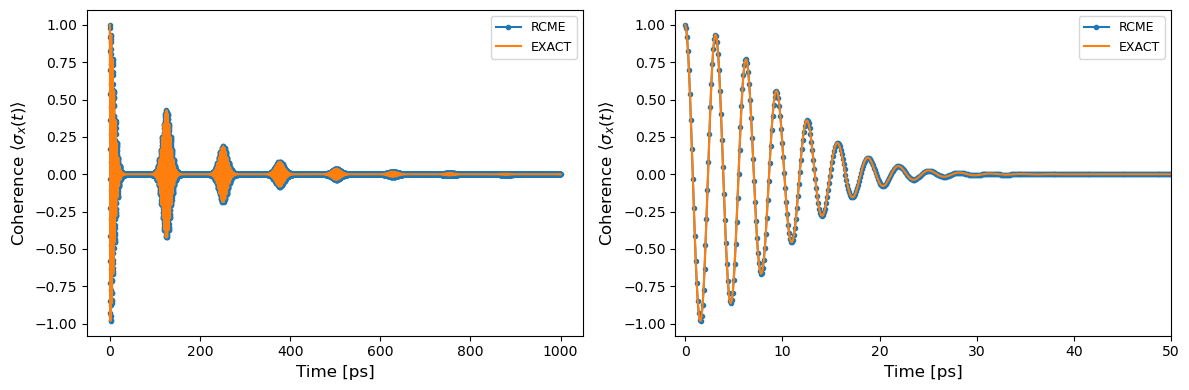

In [14]:
# PLOT THE COHERENCE DYNAMICS

import matplotlib.pyplot as plt

# Set up the figure and subplots, 1 row and 2 columns for side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize for appropriate layout

# # # First subplot: Plot coherence dynamics over the full time scale
ax1.plot(tlist, coherence_rcme, '.-', label='RCME')  # RCME data
ax1.plot(tlist, coherence_exact, '-', label='EXACT')  # Exact solution data
ax1.set_xlabel('Time [ps]', fontsize=fnt)  
ax1.set_ylabel(f'Coherence $\\langle \sigma_x (t) \\rangle$', fontsize=fnt) 
ax1.legend(fontsize=fnt*0.75)  

# # # Second subplot: Plot coherence dynamics on a shorter time scale
ax2.plot(tlist, coherence_rcme, '.-', label='RCME')  # Same data as the first plot
ax2.plot(tlist, coherence_exact, '-', label='EXACT')  # Same exact solution data
ax2.set_xlabel('Time [ps]', fontsize=fnt)
ax2.set_ylabel(f'Coherence $\\langle \sigma_x (t) \\rangle$', fontsize=fnt) 
ax2.legend(fontsize=fnt*0.75)  
ax2.set_xlim(-1, 50)  # Set limits for a shorter time scale

# # # Show the plot
plt.tight_layout()  # Adjust layout so subplots do not overlap
plt.show()


# 4) Calculate the Heat Characteristic Function (Figure 2)

In [15]:
# we must evaluate the characteristic function at a particular time

# choose which time to evaluate it at
t_sample = -1 # final element of tlist
t_cf = tlist[t_sample] # time corresponding to this element of tlist


In [16]:
# # Choose chi values to find the characteristic function for

chi_max = 0.5
chi_step = 0.1

chi_list = np.arange(0, chi_max+chi_step, chi_step) # for calculating CFs
chi_plot = np.arange(-chi_max, chi_max+chi_step, chi_step) # for plotting purposes


In [17]:
# exact solution

# cutoff for \omega integrals
cutoff = 10*w0

cf_exact = []

for chi in tqdm(chi_list):
    
    integral_real = quad(cf_int_real, 0, cutoff, args=(aud, Gamma, w0, beta, t_cf, chi), epsabs=epsilon, epsrel=epsilon, limit=int_limit,)[0]
    
    integral_imag = quad(cf_int_imag, 0, cutoff, args=(aud, Gamma, w0, t_cf, chi), epsabs=epsilon, epsrel=epsilon, limit=int_limit,)[0]
    
    cf_exact.append(np.exp(-2*(integral_real - 1j*integral_imag)))


  0%|          | 0/6 [00:00<?, ?it/s]

In [33]:
# RC solution

cf_rc_fullbath = [] # empty list to store cf for full bath definition, calculated using rc method
residualbathstates = [] # empty list to store states in, which we use to calculate cf for residual bath def

ic_rb = CFD_IC(rho_s_0, 0,   beta, H_rc) # residual bath definition, initial condition (independent of chi)

for chi in tqdm(chi_list):
    
    # find initial condition for full bath definition for this value of chi
    ic_fb = CFD_IC(rho_s_0, chi, beta, H_rc) # full bath definition
    
    # build L(chi)
    L_chi = L(chi, A, E_val_es, E_vec_es, beta, gam)
    
    # define expectation operator for full bath definition for this value of chi
    expect_fullbath = qutip.tensor(qeye(2),(1j*chi*H_rc).expm())
    
    #run master equations:
    
        # full bath definition
    result_fullbath = mesolve(L_chi, ic_fb, tlist, [] , e_ops = [expect_fullbath]) 
        
        # residual bath definition
    result_residualbath = mesolve(L_chi, ic_rb, tlist, [] , e_ops = [], 
                       options = Options(store_states='True'))
    
    #extract expectation operator for full bath definition
    cf_rc_fullbath.append(result_fullbath.expect[0][t_sample])
    
    #store states for residual bath at the sample time, to take the trace of later
    residualbathstates.append(result_residualbath.states[t_sample])



  0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
# residual bath - take the trace of the chi-dependent states

cf_rc_residualbath = []

for j in range(len(chi_list)):
    
    cf_rc_residualbath.append(mike_trace(residualbathstates[j].full()))


In [21]:
# use symmetry properties of the CF to extend to negative chi values

# first convert them into arrays
cf_rc_fullbath = np.array(cf_rc_fullbath)
cf_rc_residualbath = np.array(cf_rc_residualbath)

# use 'rev' function to perform Phi(chi) = Phi(-chi)^{*}
cf_ex_fb = rev(np.array(cf_exact))
cf_rc_fb = rev(cf_rc_fullbath)
cf_rc_rb = rev(cf_rc_residualbath)


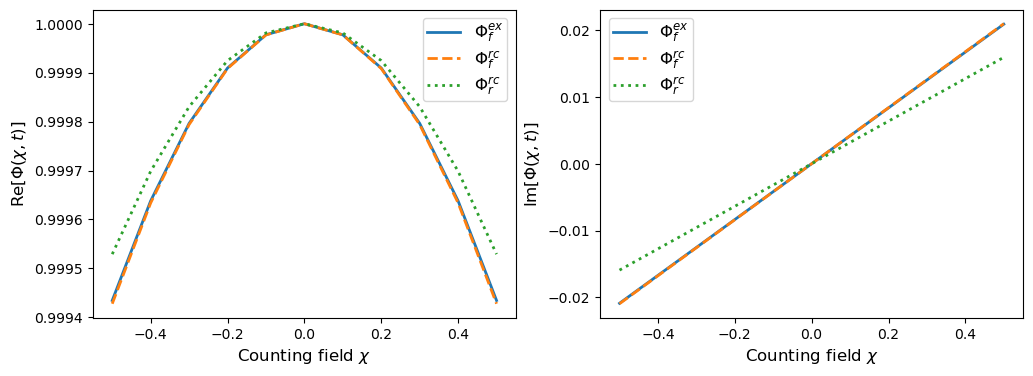

In [22]:
# PLOT THE HEAT CHARACTERISTIC FUNCTIONS

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# real part
axes[0].plot(chi_plot, cf_ex_fb.real, '-',  linewidth=2, markersize=1, label='$\\Phi_{f}^{ex}$')
axes[0].plot(chi_plot, cf_rc_fb.real, '--', linewidth=2, markersize=7, label='$\\Phi_{f}^{rc}$')
axes[0].plot(chi_plot, cf_rc_rb.real, ':',  linewidth=2, markersize=3, label='$\\Phi_{r}^{rc}$')
axes[0].set_xlabel(f'Counting field $\chi$', fontsize = fnt)
axes[0].set_ylabel(f'Re[$\Phi(\chi,t)$]', fontsize = fnt)
axes[0].legend(fontsize = 1*fnt, loc='best', markerscale=0.75, borderpad=0.25, labelspacing=0.25)

# imag part
axes[1].plot(chi_plot, cf_ex_fb.imag, '-',  linewidth=2, markersize=1, label='$\\Phi_{f}^{ex}$')
axes[1].plot(chi_plot, cf_rc_fb.imag, '--', linewidth=2, markersize=7, label='$\\Phi_{f}^{rc}$')
axes[1].plot(chi_plot, cf_rc_rb.imag, ':',  linewidth=2, markersize=3, label='$\\Phi_{r}^{rc}$')
axes[1].set_xlabel(f'Counting field $\chi$', fontsize = fnt)
axes[1].set_ylabel(f'Im[$\Phi(\chi,t)$]', fontsize = fnt)
axes[1].legend(fontsize = 1*fnt, loc='best', markerscale=0.75, borderpad=0.25, labelspacing=0.25)
plt.show()

# 5) Calculate the first two Statistical Moments (Figure 4)

In [23]:
# analytic results, found using Eqs 

mean_exact_t = []
var_exact_t = []

cutoff=5*w0 # hard cutoff for frequency integrals

for t in tqdm(tlist):
    mean_exact_t.append(exact_mean(aud, Gamma, w0, t))
    var_exact_t.append(exact_var(aud, Gamma, w0, beta, t))
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
# RC result

# define timelist for moments (can be used to skip timesteps for longer time ranges)
tlist_moms = np.arange(t0, tf, step = tstep*1)

# small value of counting parameter for numerical derivatives
chi_eps = 0.005 

# create L(chi) for chi=chi_eps
L_chi_eps = L(chi_eps, A, E_val_es, E_vec_es, beta, gam)

# find initial conditions for this value of chi
ic_fb = CFD_IC(rho_s_0, chi_eps, beta, H_rc)    # full bath definition
ic_rb = CFD_IC(rho_s_0, 0, beta, H_rc)          # residual bath definition - independent of chi

#define expectation operator
expect_fb = qutip.tensor(qeye(2),(1j*chi_eps*H_rc).expm()) # full bath definition


In [25]:
#run master equations

# full bath definition
result_fb = mesolve(L_chi_eps, ic_fb, tlist_moms, e_ops = [expect_fb],  
                       options = Options(store_states='False', 
                       atol=9e-17, rtol=9e-17, 
                       nsteps=100000000000), 
                       progress_bar=True)

# residual bath definition
result_rb = mesolve(L_chi_eps, ic_rb, tlist_moms, 
                       options = Options(store_states='True', 
                       atol=9e-17, rtol=9e-17, 
                       nsteps=100000000000), 
                       progress_bar=True)

cf_rc_fullbath_moments = result_fb.expect[0] # extract expectation value for full bath definition
residualstates_moments = result_rb.states    # extract states for residual bath definition

10.0%. Run time:   5.96s. Est. time left: 00:00:00:53
20.0%. Run time:  11.76s. Est. time left: 00:00:00:47
30.0%. Run time:  17.61s. Est. time left: 00:00:00:41
40.0%. Run time:  23.47s. Est. time left: 00:00:00:35
50.0%. Run time:  29.35s. Est. time left: 00:00:00:29
60.0%. Run time:  35.19s. Est. time left: 00:00:00:23
70.0%. Run time:  41.08s. Est. time left: 00:00:00:17
80.0%. Run time:  46.90s. Est. time left: 00:00:00:11
90.0%. Run time:  52.74s. Est. time left: 00:00:00:05
Total run time:  58.56s
10.0%. Run time:   5.94s. Est. time left: 00:00:00:53
20.0%. Run time:  11.84s. Est. time left: 00:00:00:47
30.0%. Run time:  17.66s. Est. time left: 00:00:00:41
40.0%. Run time:  23.49s. Est. time left: 00:00:00:35
50.0%. Run time:  29.30s. Est. time left: 00:00:00:29
60.0%. Run time:  35.10s. Est. time left: 00:00:00:23
70.0%. Run time:  40.93s. Est. time left: 00:00:00:17
80.0%. Run time:  46.74s. Est. time left: 00:00:00:11
90.0%. Run time:  52.53s. Est. time left: 00:00:00:05
Tota

In [34]:
# calculate CF from residual bath definition states

# turn each state into a matrix
residualstates_matrix = [state.full() for state in residualstates_moments] 

# take the trace of these matrices
cf_rc_residualbath_moments = [mike_trace(state) for state in residualstates_matrix] 

In [27]:
# calculate mean and variance at each timestep using finite differences

mean_fb_t=[]
var_fb_t=[]

mean_rb_t=[]
var_rb_t=[]

for c, t in enumerate(tlist_moms):
    
    # calculate mean and variance for full bath definition
    mean_fb, var_fb = mean_var_heat(chi_eps, cf_rc_fullbath_moments[c])
    mean_fb_t.append(mean_fb)
    var_fb_t.append(var_fb)  
    
    # calculate mean and variance for residual bath definition
    mean_rb, var_rb = mean_var_heat(chi_eps, cf_rc_residualbath_moments[c])
    mean_rb_t.append(mean_rb)
    var_rb_t.append(var_rb)  

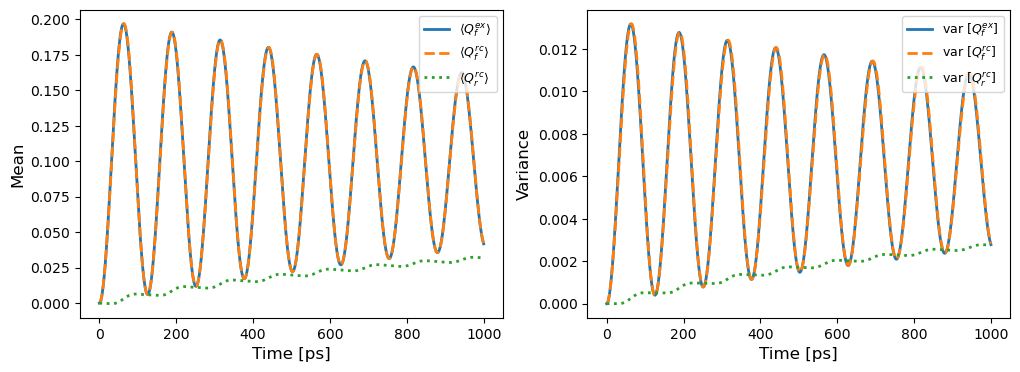

In [28]:
# PLOT MEAN AND VARIANCE

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# mean 
axes[0].plot(tlist, mean_exact_t, '-',linewidth=2, label='$\\langle Q_{f}^{ex} \\rangle$')
axes[0].plot(tlist_moms, mean_fb_t,  '--', markersize=7,linewidth=2,label='$\\langle Q_{f}^{rc} \\rangle$')
axes[0].plot(tlist_moms, mean_rb_t, ':',markersize=3,linewidth=2,label='$\\langle Q_{r}^{rc} \\rangle$')
axes[0].set_xlabel(f'Time [ps]', fontsize = fnt)
axes[0].set_ylabel(f'Mean', fontsize = fnt)
axes[0].legend(fontsize = 0.75*fnt, loc='upper right')

# variance
axes[1].plot(tlist, var_exact_t, '-',linewidth=2, label='var $[Q_{f}^{ex}]$')
axes[1].plot(tlist_moms, var_fb_t,'--', markersize=7,linewidth=2,label='var $[Q_{f}^{rc}]$')
axes[1].plot(tlist_moms, var_rb_t, ':',markersize=3,linewidth=2,label='var $[Q_{r}^{rc}]$')
axes[1].set_xlabel(f'Time [ps]', fontsize = fnt)
axes[1].set_ylabel(f'Variance', fontsize = fnt)
axes[1].legend(fontsize = 0.75*fnt, loc='upper right')


Below are results omitted from the paper but which provide interesting insights into the behaviour.

# 6) Calculate additional properties

In [29]:
# calculate von neumann entropies of TLS, extended system and RC states

entropy_S = []
entropy_ES = []
entropy_RC = []

for i in tqdm(range(len(rho_es_t))):

    entropy_S.append(entropy_vn(rho_es_t[i].ptrace(0)))    
    entropy_RC.append(entropy_vn(rho_es_t[i].ptrace(1)))    
    entropy_ES.append(entropy_vn(rho_es_t[i]))

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, 'von Neumann Entropy')

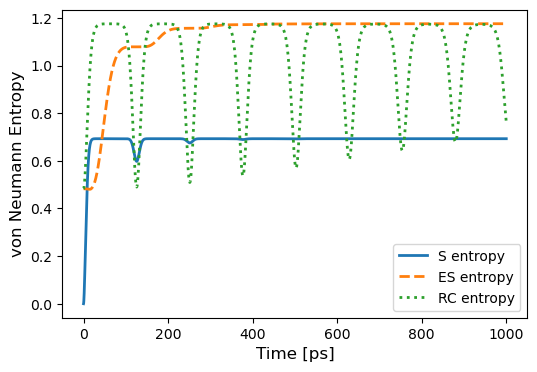

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(tlist, entropy_S,  '-', linewidth=2, markersize=12, label='S entropy')
ax.plot(tlist, entropy_ES, '--', linewidth=2,markersize=12, label='ES entropy')
ax.plot(tlist, entropy_RC, ':',linewidth=2, markersize=12, label='RC entropy')

ax.legend(fontsize=10)

ax.set_xlabel('Time [ps]',fontsize=fnt)
ax.set_ylabel(f'von Neumann Entropy',fontsize=fnt)


In [31]:
# calculate purities of TLS, extended system and RC states

purity_ES = []
purity_S = []
purity_RC = []

for c in range(len(rho_es_t)):
    
    p_ES = ((rho_es_t[c])**2).tr()
    purity_ES.append(p_ES)
    
    p_S = ((rho_es_t[c].ptrace(0))**2).tr()
    purity_S.append(p_S)

    p_RC = ((rho_es_t[c].ptrace(1))**2).tr()
    purity_RC.append(p_RC)



Text(0, 0.5, 'Purity Tr[$\\rho^{2}$]')

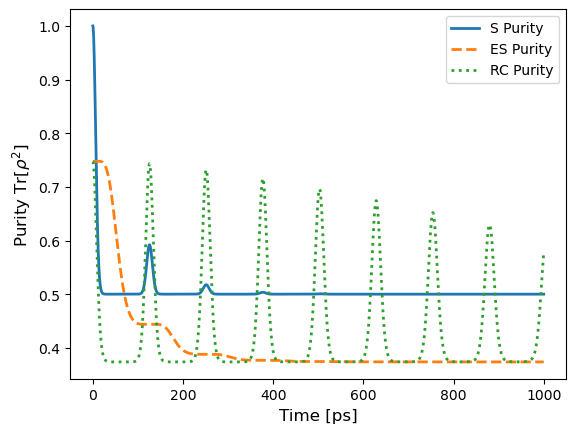

In [32]:
plt.plot(tlist, purity_S, '-', linewidth=2, label='S Purity')
plt.plot(tlist, purity_ES, '--', linewidth=2,label='ES Purity')
plt.plot(tlist, purity_RC, ':', linewidth=2,label='RC Purity')
plt.legend(fontsize=10)

plt.xlabel('Time [ps]',fontsize=fnt)
plt.ylabel(f'Purity Tr[$\\rho^{{2}}$]',fontsize=fnt)
